In [24]:
#cd '/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil'

#### SALES PIVOT AND ACTIVITY STATUS MODULE

In [255]:
import numpy as np 
import psycopg2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Credentials for DB
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT sold_to_party_code,billing_date,bill_quantity FROM dalmia_sales.sales_data where billing_date > '2020-04-01' and sold_to_party_code between 7000000 and 7099999"



class DB_Data:
    
    def __init__(self, host, database, user, password, sql_query):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.sql_query = sql_query
        
#Database connection funtion        
    def db_data(self):
        conn = psycopg2.connect(
            host=self.host,
            database=self.database,
            user=self.user,
            password=self.password
        )
        sql_query = self.sql_query
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df

#Function to create date columns 
    def create_date_columns(self):
        df = self.db_data()
        new_df = pd.DataFrame()
        for df_item in [df]:
            df_item['date'] = pd.to_datetime(df_item['billing_date'])
            df_item['Month_Year'] = pd.to_datetime(df_item['date']).dt.strftime('%Y-%m')
            df_item['Year'] = pd.to_datetime(df_item['date']).dt.year
            df_item['Quarter'] = df_item['date'].dt.to_period('Q')
            new_df = pd.concat([new_df, df_item], axis=0)
        return new_df

#Pivot data creation for 
    def pivot_data(self):
        df = self.create_date_columns()
        df_sales = df[['sold_to_party_code', 'Month_Year', 'bill_quantity']]
        df_group_month = df_sales.groupby(['sold_to_party_code', 'Month_Year']).agg({'bill_quantity': 'sum'}).reset_index()
        df_group_month.columns = ['Sold To Party Code', 'Month Year', 'Sum']
        pivot_table = pd.pivot_table(df_group_month, values='Sum', columns='Month Year', index='Sold To Party Code')
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
#New Dealers    
    def count_zeros_before_first_nonzero(self , row):
        count = 0
        for value in row:
            if value == 0:
                count += 1
            else:
                break 
        return count

#Result_matrix creation
    def count_trailing_zeros_before_end_index(self, df, end_index):
        counts = []
        for row in df.itertuples(index=False):
            count = 0
            for i in range(end_index - 1, -1, -1):
                if row[i] == 0:
                    count += 1
                else:
                    break
            counts.append(count)
        return counts

    def create_result_matrix(self):
        df = self.pivot_data()
        df['month_new_dealer'] = df.apply(self.count_zeros_before_first_nonzero,axis =1)
        #df = df[df['month_new_dealer']<=15]
        result_matrix = pd.DataFrame(index=df.index)
        for i in range(len(df.columns)):
            string = str(i)
            result_matrix[string] = self.count_trailing_zeros_before_end_index(df, i)
        result_matrix.drop('0', axis=1, inplace=True)
        return df , result_matrix
    
    def inactive(self , value):
        if value == 0: 
            return 'Active'
        elif value == 1: 
            return 'Active_1N'
        elif value == 2: 
            return 'Active_2N'
        elif value == 3: 
            return 'Active_3N'
        elif value>3 and value <=12:
            return 'Inactive'
        else: 
            return 'Churn'
        
#Activity Matrix      
    def state_matrix(self):
        df, result_matrix = self.create_result_matrix()
        for i in result_matrix.columns:
            result_matrix[i] = result_matrix[i].apply(self.inactive)
        result_matrix['month_new_dealer'] = df['month_new_dealer']
        for i in result_matrix.index:
            value = df.loc[i,'month_new_dealer'] 
            result_matrix.loc[i, :value] = '-'
        result_matrix.columns = df.columns
        #df.drop('month_new_dealer', axis = 1 , inplace = True)
        #result_matrix.drop('month_new_dealer', axis = 1 , inplace = True)
        return df, result_matrix
instance = DB_Data(host, database, user, password, sql_query)

In [ ]:
'MM-DD-YYYY'

#### DATA PREPARATION MODULE

In [256]:
from sklearn.preprocessing import LabelEncoder
class Train:
    
    def __init__(self):
        # Create an instance of the DB_Data class with appropriate parameters
        self.db_data_instance = DB_Data(host, database, user, password, sql_query)

#training data 
    def train_data(self, pivot,result_matrix):
        cols = list(pivot.columns)
        col_inv = cols[::-1]
        df_inv = pivot[col_inv]
        
        # Call the count_zeros_before_first_nonzero function from the DB_Data instance
        df_inv['zero_count'] = df_inv.apply(self.db_data_instance.count_zeros_before_first_nonzero, axis=1)
        df_inv = df_inv[df_inv['zero_count'] <= 12]
        #target variable for the training data 
        result_matrix = result_matrix[result_matrix.index.isin(df_inv.index)]
    
        result_matrix_2 = result_matrix.drop([ '2023-05', '2023-06', '2023-07', '2023-08','month_new_dealer'],axis = 1)
        result_matrix_2 = result_matrix_2[list(result_matrix_2.columns)[::-1]]
        result_matrix['zero_count'] = df_inv['zero_count']
        print(result_matrix_2.shape)
        print(df_inv.shape)
        test = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'], index=df_inv.index)
        
        result_1 = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12'], index=df_inv.index)
        
        #rolling window data for training
        for i in range(len(df_inv.index)):
            value = df_inv.iloc[i, -1]
            test.iloc[i, :] = df_inv.iloc[i, value:value+24]
            result_1.iloc[i,:] = result_matrix_2.iloc[i, value:value+12]
            
       
        y = pd.DataFrame(columns = ['state_m','state_m+1','state_m+2'], index = result_matrix.index)
        for i in range(result_matrix.shape[0]):
            value = df_inv.iloc[i , -1]
            #print(i)
            y.iloc[i,] = result_matrix.iloc[i , 29-value-4:29-value-1]     
        return test,y, result_1


    def data(self , test, result_1):
        df = pd.DataFrame()
        df[['m-1','m-2','m-3']]=test[['m-1','m-2','m-3']]
        df['m-1_yoy'] = test['m-1']-test['m-13']
        df['m-2_yoy'] = test['m-2']-test['m-14']
        df['m-3_yoy'] = test['m-3']-test['m-15']
        df['m-1_hy'] = test['m-1']-test['m-7']
        df['m-2_hy'] = test['m-2']-test['m-8']
        df['m-3_hy'] = test['m-3']-test['m-9']
        df['m-1_qoq'] = test['m-1']-test['m-4']
        df['m-2_qoq'] = test['m-2']-test['m-5']
        df['m-3_qoq'] = test['m-3']-test['m-6']
        test['avg_sales'] = test.mean(axis = 1)
        df = df.merge(test['avg_sales'], left_index = True , right_index = True , how = 'inner')
        status_columns = result_1.columns[1:]  # Exclude the "Identifier" column
        for index, row in result_1.iterrows():
            row_counts = row[status_columns].value_counts()
            for status_col, count in row_counts.items():
                result_1.at[index, f"{status_col}_count"] = count
        result_1 = result_1[['Active_1N_count','Active_2N_count','Active_3N_count','Inactive_count']]
        result_1 = result_1.fillna(0)
        df = df.merge(result_1, left_index = True , right_index=True , how = 'inner')
        
        return df
    
    def discount_pd(self, df , discount_df , pd_df):
        df = df.merge(discount_df['avg_discount'], left_index= True , right_index = True,
                     how = 'left').merge(pd_df['avg_pd'], left_index = True , right_index = True, how = 'left')
        return df
    
    def district(self , df , distt_df, region_df):
        df = df.merge(distt_df['sold_to_party_district_name'], left_index = True , 
                      right_index = True , how = 'inner').merge(region_df['sales_region'] , left_index = True , 
                                                                right_index = True , how = 'left')
        le = LabelEncoder()
        df['sold_to_party_district_name'] = le.fit_transform( df['sold_to_party_district_name'])
        df['sales_region'] = le.fit_transform( df['sales_region'])
        return df

#### TRAINING DATA PREPARATION

In [263]:
pivot, result_matrix = instance.state_matrix()
pivot_prev = pd.read_csv('previous_year_data.csv')
pivot_prev.index = pivot_prev['Sold To Party Code']
pivot_prev.drop('Sold To Party Code', axis = 1 , inplace = True)
pivot_1 = pivot_prev.merge(pivot , left_index = True , right_index=True , how = 'right')
pivot_1 = pivot_1.fillna(0)
pivot_2 = pivot_1.drop(['2023-05', '2023-06', '2023-07', '2023-08','month_new_dealer'],axis = 1)
result_matrix_2 = result_matrix.drop([ '2023-07', '2023-08','month_new_dealer'],axis = 1)
# Discount Data
discount_df = pd.read_excel('updated_discount_df.xlsx')
pd_df = pd.read_excel('update_df.xlsx')
discount_df.index = discount_df['Sold To Party Code']
pd_df.index = pd_df['Sold To Party Code']
discount_df['avg_discount'] = discount_df[['2022-04','2022-05','2022-06','2022-07','2022-08','2022-09','2022-10',
                                           '2022-11','2022-12', '2023-01', '2023-02', '2023-03']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-04','2022-05','2022-06','2022-07','2022-08','2022-09','2022-10',
                                           '2022-11','2022-12', '2023-01', '2023-02', '2023-03']].mean(axis = 1)
#district and region_data
distt_df = pd.read_csv('data/unique_districts.csv')
region_df = pd.read_csv('data/unique_region.csv')
distt_df.index = distt_df['sold_to_party_code']
region_df.index = region_df['sold_to_party_code']

OperationalError: could not translate host name "database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com" to address: nodename nor servname provided, or not known


In [ ]:
instance_2 = Train()
test , y ,result_1= instance_2.train_data(pivot_2,result_matrix)

In [172]:
train_df = instance_2.data(test , result_1)
train_df = instance_2.discount_pd(train_df , discount_df , pd_df)
train_df = instance_2.district(train_df , distt_df, region_df)
train_df = train_df.fillna(0)

#### TRAINER MODULE

In [173]:
#training module
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib

class Training_module:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    def train_decision_tree(self):
        model = DecisionTreeClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Decision Tree_1")
        self.save_model(model, "Decision_Tree_1") 

    def train_svm(self):
        model = SVC(probability=True,kernel='rbf')
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "SVM_1")
        self.save_model(model, "SVM_1")

    def train_random_forest(self):
        model = RandomForestClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Random Forest_1")
        self.save_model(model, "Random Forest_1")

    def train_knn(self):
        model = KNeighborsClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "K-Nearest Neighbors_1")
        self.save_model(model, "K-Nearest Neighbors_1")

    def train_xgboost(self):
        model = XGBClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost_1")
        self.save_model(model, "XGBoost_1")

    def train_xgboost_rf(self):
        model = XGBRFClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost Random Forest_1")
        self.save_model(model, "XGBoost Random Forest_1")

    def evaluate_model(self, model, model_name):
        y_pred = model.predict(self.X_test)
        y_prob = model.predict_proba(self.X_test)[:, 1]

        print(f"Classification Report for {model_name}:\n")
        print(classification_report(self.y_test, y_pred))

        print(f"Confusion Matrix for {model_name}:\n")
        print(confusion_matrix(self.y_test, y_pred))

        self.plot_roc_curve(model, model_name, y_prob)

    def plot_roc_curve(self, model, model_name, y_prob):
        n_classes = len(set(self.y))

        if n_classes == 2:
            self.plot_binary_roc_curve(model_name, self.y_test, y_prob)
        else:
            self.plot_multiclass_roc_curve(model_name, self.y_test, y_prob, n_classes)

    def plot_binary_roc_curve(self, model_name, y_test, y_prob):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

    def plot_multiclass_roc_curve(self, model_name, y_test, y_prob, n_classes):
        y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multiclass ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def save_model(self, model, model_name):
        filename = f"{model_name}_model.pkl"
        joblib.dump(model, filename)

    def load_model(self, model_name):
        filename = f"{model_name}_model.pkl"
        return joblib.load(filename)
        
    def validate_saved_model(self, model_name, X_val , y_val):
        loaded_model = self.load_model(model_name)
        # You can use the loaded model for validation or inference
        y_pred = loaded_model.predict(X_val)
        y_prob = loaded_model.predict_proba(X_val)[:, 1]
        print(f"Validation Results for {model_name}:\n")
        print(classification_report(y_val, y_pred))
        print(confusion_matrix(y_val, y_pred))
        self.plot_binary_roc_curve(loaded_model, y_val, y_prob)
        return y_pred  ,y_prob


In [174]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(train_df)
y = y[y.index.isin(train_df.index)]
y_1 = y['state_m'].replace({'Active':0, 'Active_1N':1})
trainer = Training_module(X, y_1)

Classification Report for Random Forest_1:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2914
           1       0.78      0.70      0.73      1354

    accuracy                           0.84      4268
   macro avg       0.82      0.80      0.81      4268
weighted avg       0.84      0.84      0.84      4268

Confusion Matrix for Random Forest_1:

[[2640  274]
 [ 409  945]]


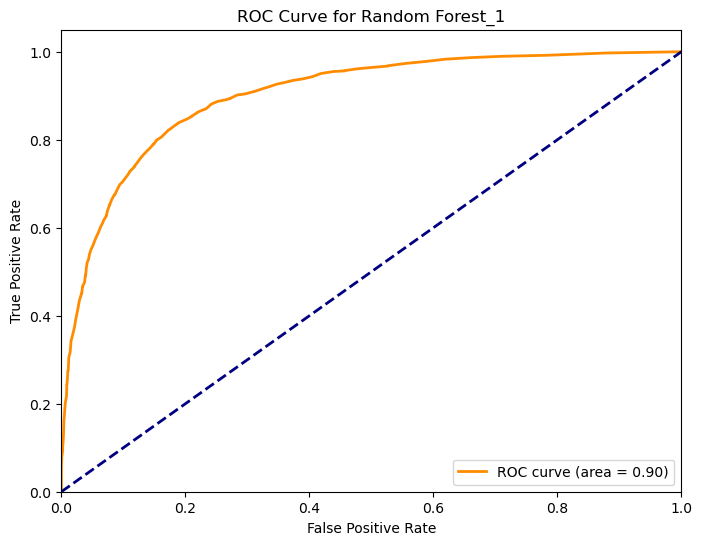

In [177]:
trainer.train_random_forest()

Classification Report for SVM_1:

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2914
           1       0.71      0.56      0.63      1354

    accuracy                           0.79      4268
   macro avg       0.76      0.73      0.74      4268
weighted avg       0.78      0.79      0.78      4268

Confusion Matrix for SVM_1:

[[2595  319]
 [ 591  763]]


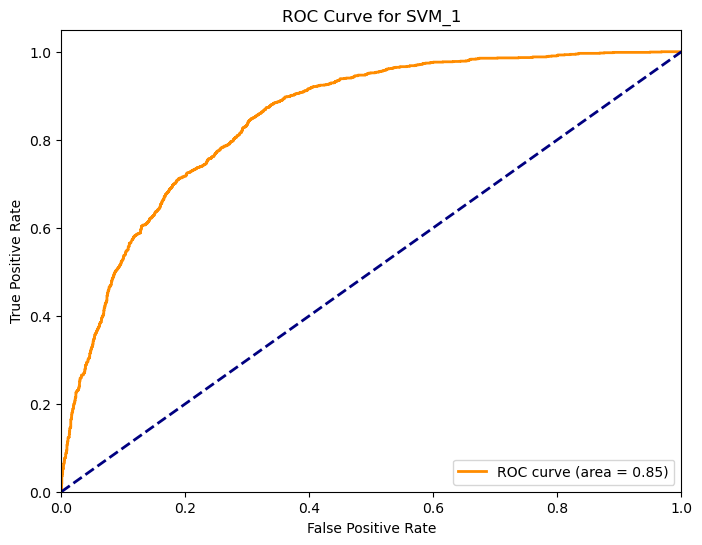

In [176]:
trainer.train_svm()

#### MONTH DATA PREPARATION FOR VALIDATION/ENGAGEMENT LIST

In [246]:
#engagement list generation module
discount_df['avg_discount'] = discount_df[['2022-08','2022-09','2022-10',
                                           '2022-11','2022-12', '2023-01', '2023-02', '2023-03','2023-04','2023-05','2023-06','2023-07']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-07','2022-08','2022-09','2022-10',
                                           '2022-11','2022-12', '2023-01', '2023-02', '2023-03','2023-04','2023-05','2023-06','2023-07']].mean(axis = 1)
result_jun = result_matrix[result_matrix['2023-07']=='Active']
pivot_jun = pivot[pivot.index.isin(result_jun.index)]
pivot_jun = pivot_jun[['2021-08','2021-09','2021-10','2021-11','2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
result_jun_1 = result_jun[[ '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18','m-19','m-20','m-21','m-22','m-23','m-24'][::-1]

result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]

val_df = instance_2.data(pivot_jun, result_jun_1)
val_df = instance_2.discount_pd(val_df , discount_df[['avg_discount']], pd_df[['avg_pd']])
val_df = instance_2.district(val_df , distt_df , region_df)
val_df = val_df.fillna(0)

In [247]:
#prediction through saved model
import joblib
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_jun = sc.fit_transform(val_df)
loaded_model = joblib.load('Random Forest_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jun)
pred_proba = loaded_model.predict_proba(X_jun)[:,1]
val_df['predicted'] = predictions
val_df['predict_proba'] = pred_proba

#### EVALUATION PART(RUN THIS PART TO CHECK THE PREVIOUS MONTH PREDICTION)

In [248]:
#validation for the given month
val_df['actual'] = result_matrix['2023-08']
val_df['predicted'] = val_df['predicted'].replace({0:'Active',1:'Active_1N'})
print(classification_report(val_df['actual'], val_df['predicted']))
print(confusion_matrix(val_df['actual'], val_df['predicted']))

              precision    recall  f1-score   support

      Active       0.97      0.73      0.83      9261
   Active_1N       0.18      0.75      0.29       731

    accuracy                           0.73      9992
   macro avg       0.58      0.74      0.56      9992
weighted avg       0.92      0.73      0.79      9992

[[6747 2514]
 [ 181  550]]


In [219]:
condition = (val_df['predict_proba'] <0.55) 
val_df.loc[condition, 'predicted'] = 'Active'

In [220]:
print(classification_report(val_df['actual'], val_df['predicted']))
print(confusion_matrix(val_df['actual'], val_df['predicted']))

              precision    recall  f1-score   support

      Active       0.96      0.78      0.86      9261
   Active_1N       0.19      0.64      0.29       731

    accuracy                           0.77      9992
   macro avg       0.58      0.71      0.58      9992
weighted avg       0.91      0.77      0.82      9992

[[7246 2015]
 [ 266  465]]


In [249]:
#L3M prediction report
result_matrix_1N_2N = result_matrix[result_matrix['2023-07'].isin(['Active_1N','Active_2N'])]
df = val_df[['actual','predicted']]
result_matrix_1N_2N = result_matrix_1N_2N[['2023-08']]
result_matrix_1N_2N['predicted'] = 1
result_matrix_1N_2N.columns = ['actual','predicted']
df = pd.concat([df,result_matrix_1N_2N],axis = 0)
df = df.replace({'Active':0,'Active_1N':1,'Active_2N':1, 'Active_3N':1})
print(classification_report(df['actual'],df['predicted']))
print(confusion_matrix(df['actual'],df['predicted']))

              precision    recall  f1-score   support

           0       0.97      0.69      0.81      9762
           1       0.32      0.89      0.47      1601

    accuracy                           0.72     11363
   macro avg       0.65      0.79      0.64     11363
weighted avg       0.88      0.72      0.76     11363

[[6747 3015]
 [ 181 1420]]


#### ENGAGEMENT LIST GENERATION

In [244]:
df_2 = val_df.merge(pivot['month_new_dealer'], left_index = True , right_index = True)
df_2 = df_2[['predicted','month_new_dealer']]
df_2 = df_2[df_2['predicted']=='Active_1N']

In [245]:
df_2

,predicted,month_new_dealer
7000010,Active_1N,0
7000040,Active_1N,0
7000067,Active_1N,0
7000086,Active_1N,0
7000125,Active_1N,0
...,...,...
7041465,Active_1N,27
7041469,Active_1N,27
7041475,Active_1N,27
7041477,Active_1N,27
